In [23]:
import re
import os
import json
from PIL import Image

import torch
import numpy as np
from tqdm import tqdm

import faiss
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel

root = "results/"
image_root = "F:/train_blocks"

In [2]:
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [3]:
def cap_post_process(caption):
    answers = []
    
    caps = re.split("CAP\s*\d*\s*[:=-]", caption)[1:]
    for cap in caps:
        if re.search("\d{2,}", cap):
            continue
        cap = cap.strip()
        cap = re.sub("^[\'\"]", "", cap)
        cap = re.sub("[\'\"]$", "", cap)
        answers.append(cap)
    return answers

def record_post_process(record):
    answers = {}
    
    for key, item in record.items():
        extracted_captions = []
        for caption in item["response"]:
            
            extracted_captions.extend(cap_post_process(caption))
        answers[key] = extracted_captions
    
    return answers

In [4]:
records = {}

for file_name in os.listdir(root):
    file_name_capture = re.search("records_(\d_[1-9]\d?)", file_name)
    if file_name_capture:
        file_id = file_name_capture.group(1)
        
        with open(os.path.join(root, file_name), "r") as f:
            record = record_post_process(json.load(f))
        records[file_id] = record

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

D:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


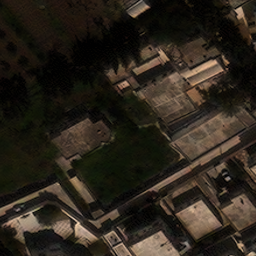

In [53]:
image

In [48]:
sim_records = {}

for record_id, record in records.items():
    if record_id == "0_1":
        continue
    for key, captions in record.items():
        image = Image.open(os.path.join(image_root, f"{key}.png"))
        inputs = processor(text=captions + ["a cat"], images=image, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        break
    break

In [49]:
captions_array = np.array(captions + ["a cat"])

In [50]:
sorted_indices = np.argsort(outputs.logits_per_image[0].detach().numpy())[::-1]

In [51]:
outputs.logits_per_image[0].detach().numpy()[sorted_indices]

array([31.350168, 31.025824, 30.901922, 30.515787, 30.386406, 30.236092,
       30.185266, 30.05999 , 29.993208, 29.98081 , 29.925995, 29.623564,
       29.597374, 29.45525 , 29.43065 , 29.232107, 29.214981, 29.188152,
       29.006079, 28.98182 , 28.721973, 28.583952, 28.366207, 28.343855,
       28.219797, 28.18656 , 28.086308, 28.065895, 28.054441, 27.941397,
       27.932589, 27.834793, 27.71163 , 27.646627, 27.616869, 27.603762,
       27.496286, 27.431639, 27.413095, 27.407822, 27.279213, 27.194002,
       27.080276, 27.059748, 27.037437, 26.989027, 26.89038 , 26.798405,
       26.78367 , 26.74097 , 26.613094, 26.39619 , 26.322653, 26.301308,
       26.28823 , 26.179272, 26.138912, 26.11029 , 26.09074 , 25.8043  ,
       25.759514, 25.46328 , 25.459604, 25.423025, 25.395092, 25.23114 ,
       25.156092, 24.675657, 24.671854, 24.612137, 24.602262, 24.47859 ,
       24.261518, 24.23877 , 24.179085, 24.01067 , 23.921213, 23.321102,
       23.029516, 22.571487, 22.369669, 19.530396, 

In [52]:
captions_array[sorted_indices]

array(['Several buildings form a diagonal line across the image, ranging in size from large to small.',
       'Buildings are sparsely scattered across the image, the largest one stands out in the upper right corner.',
       'The buildings in the lower half of the image form a diagonal line',
       'Aerial view reveals an intricate assortment of buildings in diamond formation, highlighting the largest structure at the top-right corner.',
       'A cluster of buildings, ranging from small to large sizes, are evenly distributed throughout the image.',
       'A dominant building stands out among smaller structures in this aerial view',
       'The organized layout of the buildings in this aerial image is accentuated by the carefully positioned small cars in the corners.',
       'The buildings in this aerial image are arranged in a diagonal line and two small cars bookend the corners.',
       'The buildings in this aerial image are arranged in a diagonal line while the small cars fram

In [12]:
kmeans = faiss.Kmeans(embedding.shape[1], 5, niter=20, verbose=True)
kmeans.train(embedding[:30])

NameError: name 'embedding' is not defined

In [79]:
index = faiss.IndexFlatL2(embedding.shape[1])
index.add(embedding)
D, I = index.search(kmeans.centroids, 2)

In [40]:
records_10.keys()

dict_keys(['10.tif_18', '10.tif_19', '10.tif_31', '10.tif_32', '10.tif_33', '10.tif_34', '10.tif_35', '10.tif_45', '10.tif_46', '10.tif_47', '10.tif_48', '10.tif_60'])

In [80]:
for i in range(I.shape[0]):
    print([captions[i] for i in I[i, :]])

['Top and bottom right buildings cluster.', 'Clustered buildings in top right and center.']
['Mostly horizontal/vertical alignment', 'Unique damage patterns top left and center']
['Damaged buildings in top left and center top.', 'Damaged buildings are concentrated in the top left and center top, indicating a possible cause or target of the damage.']
['The construction sites in the center of the image are interposed by buildings in the top right and bottom right.', 'Buildings are dispersed across the image, except for one in the middle bottom where a construction site is located.']
['Hut or tent separate in top right', 'The hut or tent in the top right stands out amidst the permanent structures, suggesting a different social or economic status.']
